In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in the dataset
df = pd.read_excel("data/ANZ_synthesised_transaction_dataset.xlsx")

In [3]:
# Overview of the dataset
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

In [5]:
# Check if the transaction_ids are unique
df.transaction_id.is_unique

True

* The dataset contains 12043 unique transaction entries. Some of the columns have missing data.

In [6]:
print(f"Number of unique customer ids: {df.customer_id.nunique()}")

Number of unique customer ids: 100


In [7]:
print(f"Number of unique accounts: {df.account.nunique()}")

Number of unique accounts: 100


* There are 100 customers in the dataset each of whom has only one account.

In [8]:
# Find the earliest date in the dataset
min_date = df.date.min()
print(f"The earliest date in the data set: {min_date}")

The earliest date in the data set: 2018-08-01 00:00:00


In [9]:
# Find the latest date in the dataset
max_date = df.date.max()
print(f"The latest date in the data set: {max_date}")

The latest date in the data set: 2018-10-31 00:00:00


In [10]:
print(f"Number of unique dates in the data set: {df.date.nunique()}")

Number of unique dates in the data set: 91


* Transactions in the data set spanned over three months from 1st August 2018 to 31st October 2018. The dataset contains 91 unique dates while we expect 92 days over August, September and October. Hence there should be one day missing. Let's check which date is missing in the data set.

In [11]:
# Missing date from the data set
missing_date = pd.date_range(start=min_date, end=max_date).difference(df.date)
print(f"The missing date from the data set: {missing_date}.")

The missing date from the data set: DatetimeIndex(['2018-08-16'], dtype='datetime64[ns]', freq=None).


* A closer look at the data types of each column tells us that we would need to split latitudes and longitudes of customers (column long_lat) and merchants (column merchant_long_lat) into individual columns for further analysis.

In [12]:
df[["cust_long", "cust_lat"]] = df.long_lat.str.split(" ", expand=True).astype(float)

In [13]:
df[["merchant_long", "merchant_lat"]] = df.merchant_long_lat.str.split(" ", expand=True).astype(float)

In [14]:
# Delete the split columns
del df["long_lat"]
del df["merchant_long_lat"]

* Next we would explore the taxation description column to investigate different kinds of transactions. 

In [15]:
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

* Most of the merchant-related columns have the same number of non-null values. One assumption is that transactions with null merchant-related data might be inter bank transfer or salary payment. We could verify this assumption by looking at those transactions.

In [16]:
df_null_merchant = df[df.merchant_id.isnull()]
df_null_merchant.txn_description.value_counts()

PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

* As suspected, merchants are not involved in InterBank transfers or Salary payments.
* Next we will explore some other categorical variables to understand more about the data set.

In [17]:
df.status.value_counts()

authorized    7717
posted        4326
Name: status, dtype: int64

In [18]:
df.currency.value_counts()

AUD    12043
Name: currency, dtype: int64

In [19]:
df.country.value_counts()

Australia    12043
Name: country, dtype: int64

* To have an overview of customers' locations, we'll check ranges of longitudes and latitudes of customers.

In [20]:
print(f"Minimum customer's longitude is {df.cust_long.min()}")

Minimum customer's longitude is 114.62


In [21]:
print(f"Maximum customer's longitude is {df.cust_long.max()}")

Maximum customer's longitude is 255.0


In [22]:
print(f"Minimum customer's latitude is {df.cust_lat.min()}")

Minimum customer's latitude is -573.0


In [23]:
print(f"Maximum customer's latitude is {df.cust_lat.max()}")

Maximum customer's latitude is -12.37


* The minimum and maximum customer's latitudes and longitudes suggest that some customers not reside in Australia. Referring to this http://www.ga.gov.au/scientific-topics/national-location-information/dimensions/continental-extremities, we can limit latitudes from -44 to -10, and longitudes from 113 to 154 to include only customers in Australia.

In [24]:
df_short = df.loc[(df.cust_long > 113) & (df.cust_long < 154) & (df.cust_lat > -44) & (df.cust_lat < -10)]

In [25]:
print(f"The number of customers residing in Australia is {df_short.customer_id.nunique()}.")

The number of customers residing in Australia is 99.


* Only one customer resides outside Australia. However, as the country of transactions in the whole data set is only Australia with only AUD as currency, we could infer that his/her transactions happened in Australia. We will still include transactions from this special customer in our analysis.

* Next, we'll plot a boxplot and a histogram to gather some insights about the distribution of transacted amounts in the data set. As discussed in the previous analysis, transaction types PAYMENT, PAY/SALARY, INTER BANK, and PHONE BANK do not involve a merchant. Assuming that a purchase transaction must be associated with a merchant, we'll firstly exclude non-merchant-involved transactions from our data set to get some insights about purchase transactions.

In [26]:
no_merchant_trans_list = ["PAYMENT", "PAY/SALARY", "INTER BANK", "PHONE BANK"]
df_merchant = df[~df.txn_description.isin(no_merchant_trans_list)]

In [27]:
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7717 entries, 0 to 12042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             7717 non-null   object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   2 non-null      object        
 3   account            7717 non-null   object        
 4   currency           7717 non-null   object        
 5   txn_description    7717 non-null   object        
 6   merchant_id        7717 non-null   object        
 7   merchant_code      0 non-null      float64       
 8   first_name         7717 non-null   object        
 9   balance            7717 non-null   float64       
 10  date               7717 non-null   datetime64[ns]
 11  gender             7717 non-null   object        
 12  age                7717 non-null   int64         
 13  merchant_suburb    7717 non-null   object        
 14  merchan

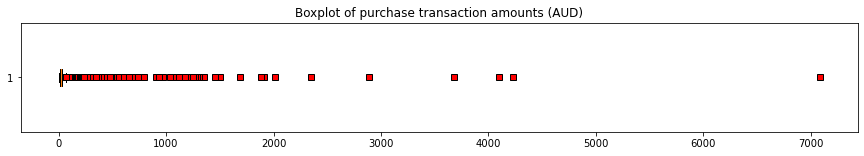

In [28]:
red_square = dict(markerfacecolor='r', marker='s')
fig1, ax1 = plt.subplots(figsize=(15, 2))
ax1.set_title('Boxplot of purchase transaction amounts (AUD)')
ax1.boxplot(df_merchant.amount, vert=False, flierprops=red_square)
plt.show()

There are quite a number of outliers. We'll plot a boxplot excluding outliers.

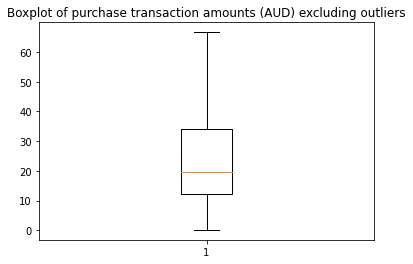

In [29]:
fig2, ax2 = plt.subplots()
ax2.set_title('Boxplot of purchase transaction amounts (AUD) excluding outliers')
ax2.boxplot(df_merchant.amount, showfliers=False)
plt.show()

As can be seen, most of the transactions valued at under $70. Let's plot a histogram